In [1]:
using Pkg
Pkg.activate("projet_env")
Pkg.add("ADNLPModels")
Pkg.add("NLPModels")
Pkg.add("Krylov")
Pkg.add("LinearOperators")

Pkg.add("Plots")

Pkg.add("OptimizationProblems")  # collection + outils pour sélectionner les problèmes
# TODO: add CUTest

using LinearAlgebra, NLPModels , ADNLPModels, Printf, Krylov, LinearOperators 

using OptimizationProblems, OptimizationProblems.ADNLPProblems

using Plots

  Activating project at `~/mth8408/projet/phase_1/projet_env`
   Resolving package versions...
  No Changes to `~/mth8408/projet/phase_1/projet_env/Project.toml`
  No Changes to `~/mth8408/projet/phase_1/projet_env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/mth8408/projet/phase_1/projet_env/Project.toml`
  No Changes to `~/mth8408/projet/phase_1/projet_env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/mth8408/projet/phase_1/projet_env/Project.toml`
  No Changes to `~/mth8408/projet/phase_1/projet_env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/mth8408/projet/phase_1/projet_env/Project.toml`
  No Changes to `~/mth8408/projet/phase_1/projet_env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/mth8408/projet/phase_1/projet_env/Project.toml`
  No Changes to `~/mth8408/projet/phase_1/projet_env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/mth8408/projet/phase_1/projet_env/Project.toml

In [3]:
meta = OptimizationProblems.meta
problem_list = meta[(meta.ncon.==0).&.!meta.has_bounds.&(meta.nvar.==100), :name]
problems = (OptimizationProblems.ADNLPProblems.eval(Meta.parse(problem))() for problem ∈ problem_list)

Base.Generator{Vector{String}, var"#11#12"}(var"#11#12"(), ["arglina", "arglinb", "arglinc", "argtrig", "arwhead", "bdqrtic", "brownal", "broyden3d", "broydn7d", "brybnd"  …  "sinquad", "sparsine", "sparsqur", "spmsrtls", "srosenbr", "tointgss", "tquartic", "tridia", "vardim", "woods"])

In [4]:
models = []
push!(models, OptimizationProblems.ADNLPProblems.chainwoo())
# push!(models, OptimizationProblems.ADNLPProblems.errinros_mod())
# push!(models, OptimizationProblems.ADNLPProblems.freuroth())

# Validation of the modified newton method
x_star = newton_inexact_trust_region(models[1])

gnorm0= 70163.67815387103
 k         fk   ‖grad‖
 0   3.72e+05  7.0e+04
 1   3.07e+05  5.9e+04
 2   1.70e+05  3.4e+04
 3   3.76e+04  1.8e+04
 4   9.92e+02  1.1e+03
 5   9.92e+02  1.1e+03
 6   9.92e+02  1.1e+03
 7   9.92e+02  1.1e+03
 8   5.24e+02  7.0e+02
 9   5.24e+02  7.0e+02
10   5.24e+02  7.0e+02
11   4.16e+02  2.2e+02
12   4.16e+02  2.2e+02
13   3.93e+02  1.0e+02
14   3.93e+02  1.0e+02
15   3.90e+02  6.7e+01
16   3.85e+02  5.0e+01
17   3.85e+02  5.0e+01
18   3.84e+02  6.2e+01
19   3.82e+02  1.0e+01
20   3.82e+02  1.0e+01
21   3.82e+02  1.9e+01
22   3.80e+02  1.8e+01
23   3.80e+02  8.5e+01
24   3.76e+02  5.2e+01
25   3.75e+02  6.9e+01
26   3.74e+02  5.5e+01
27   3.73e+02  6.1e+01
28   3.70e+02  4.3e+01
29   3.70e+02  4.3e+01
30   3.69e+02  2.1e+01
31   3.69e+02  2.1e+01
32   3.67e+02  2.4e+01
33   3.67e+02  2.4e+01
34   3.65e+02  2.0e+01
35   3.65e+02  2.0e+01
36   3.64e+02  2.9e+01
37   3.64e+02  2.9e+01
38   3.62e+02  4.5e+01
39   3.62e+02  4.5e+01
40   3.59e+02  3.6e+01
41   3.5

100-element Vector{Float64}:
 1.0000007392775394
 1.0000014822496728
 0.999999227387433
 0.9999984507104422
 1.0000008761123222
 1.000001756838127
 0.9999989407798209
 0.9999978759852222
 1.000001338511014
 1.0000026840711773
 ⋮
 1.0219978604089364
 0.9912851106163733
 0.9825991463582134
 1.0071535674531498
 1.0143951575537786
 0.9936525598092654
 0.9873112854270132
 1.0060355297056627
 1.0121403868509575

In [38]:
# Reference: https://www.gerad.ca/fr/papers/G-2019-64
function lbfgs(Bj, gk, delta; eps = 1e-5, mem = 5, max_iter = 10)

    dim = length(gk)

    k = 1
    pk = zeros(dim)

    Hk = InverseLBFGSOperator(dim, mem = mem, scaling = true)

    # TODO: use absolute and relative convergence criteria
    while norm(gk) > eps && k <= max_iter

        dk = -Hk*gk

        # TODO: review if there is a more efficient way of computing Bj*dk
        bk =  Bj*dk

        if dot(dk, bk) <= 0
            alphak = -sign(dot(gk, dk))*2*delta/norm(dk)
        else
            alphak = -dot(gk, dk)/dot(dk, bk)
        end

        sk = alphak*dk
        pk = pk + sk

        if norm(pk) >= delta
            pk = pk - sk

            # compute eq (87) such that norm(pk + tau*sk) = delta (see reference)
            tau = (-dot(pk, sk) + sqrt(dot(pk, sk)^2 + dot(sk, sk)*(delta^2 - dot(pk, pk))))/dot(sk, sk)

            return pk + tau * sk
        end

        yk = alphak*bk
        gk = gk + yk
        k = k + 1

        # update the inverse Hessian approximation
        push!(Hk, sk, yk)
        
    end

    return pk
end


mutable struct OptimizationResult
    sol::Vector         # argmin of f
    fun::Float64        # min of f
    fk::Vector          # evolution of fk
    gk_norm::Vector     # evolution of ||gk||
    converged::Bool     # convergence flag -> did the optimizer converge?
end


function newton_inexact_trust_region(model; sub_optimizer="cg", eps_a=1.0e-5, eps_r=1.0e-5, mem=10, max_iter_ratio=10)
    
    # TODO: add verbose argument

    xk = model.meta.x0
    n = length(xk)
    fk = obj(model, xk)
    gk = grad(model, xk)
    gnorm = norm(gk)
    gnorm0 = deepcopy(gnorm)
    
    k = 0
    deltak = 1.0
    @printf "%2s  %9s  %7s\n" "k" "fk" "‖grad‖"
    @printf "%2d  %9.2e  %7.1e\n" k fk gnorm

    # save convergence history
    fk_history = Vector{Float64}()
    gk_norm_history = Vector{Float64}()

    # push starting point and starting ||gk||
    push!(fk_history, fk)
    push!(gk_norm_history, gnorm)

    converged_flag = false

    max_iter = max_iter_ratio*n
    
    while gnorm > eps_a + eps_r * gnorm0 && k < max_iter
        Bk = hess(model,xk)
        ##############################
        #    Trust region update     #
        ##############################
        # select sub optimizer CG or L-BFGS
        if sub_optimizer == "cg"
            (sk, stats) = Krylov.cg(Bk, -gk,radius=deltak)
        elseif sub_optimizer == "lbfgs"
            sk = lbfgs(Bk, gk, deltak, mem=mem, max_iter=max_iter)
        else
            throw("Selected sub optimizer is not valid.")
        end
        
        ##############################
        #       Trust region         #
        ##############################
        # predicted objective reduction
        red_pred = -dot(gk, sk) - 0.5*(sk'*(Bk*sk))

        f_new = obj(model, xk .+ sk)
        
        # actual obj reduction
        red_act = fk - f_new

        # actual obj reduction to predicted obj red ratio
        rho = red_act / red_pred

        # if reduction is greater than tolerance, accept step size. Otherwise,
        # reject step size
        if rho >= 1e-4
            # update new point
            xk .+= sk
            fk = f_new
            gk .= grad(model, xk)
            gnorm = norm(gk)
        end

        # increase / decrease trust region radius
        # TODO: should be function argument
        if rho >= 0.99
            deltak *= 3
        elseif rho < 1e-4
            deltak /= 3
        end
        ##############################

        k += 1
        @printf "%2d  %9.2e  %7.1e\n" k fk gnorm

        push!(fk_history, fk)
        push!(gk_norm_history, gnorm)

    end

    # update convergence flag
    if gnorm <= eps_a + eps_r * gnorm0
        converged_flag = true
    end

    # save optimization data to OptimizationResult struct
    optimize_result = OptimizationResult(
        xk,
        fk,
        fk_history,
        gk_norm_history,
        converged_flag
    )

    # return solution and optimization history
    return xk, optimize_result
end

newton_inexact_trust_region (generic function with 5 methods)

In [39]:
models = []
push!(models, OptimizationProblems.ADNLPProblems.chainwoo())

x_star, res = newton_inexact_trust_region(models[1], sub_optimizer="lbfgs", mem=50)

 k         fk   ‖grad‖
 0   3.72e+05  7.0e+04
 1   3.07e+05  5.9e+04
 2   1.70e+05  3.4e+04
 3   3.76e+04  1.8e+04
 4   9.92e+02  1.1e+03
 5   9.92e+02  1.1e+03
 6   9.92e+02  1.1e+03
 7   9.92e+02  1.1e+03
 8   5.24e+02  7.0e+02
 9   5.24e+02  7.0e+02
10   5.24e+02  7.0e+02
11   4.16e+02  2.2e+02
12   4.16e+02  2.2e+02
13   3.93e+02  1.0e+02
14   3.93e+02  1.0e+02
15   3.90e+02  6.7e+01
16   3.85e+02  5.0e+01
17   3.85e+02  5.0e+01
18   3.84e+02  6.3e+01
19   3.82e+02  1.0e+01
20   3.82e+02  1.0e+01
21   3.82e+02  1.9e+01
22   3.80e+02  1.8e+01
23   3.80e+02  8.5e+01
24   3.76e+02  5.3e+01
25   3.75e+02  6.8e+01
26   3.74e+02  5.5e+01
27   3.73e+02  6.2e+01
28   3.70e+02  4.3e+01
29   3.70e+02  4.3e+01
30   3.69e+02  2.1e+01
31   3.69e+02  2.1e+01
32   3.67e+02  2.4e+01
33   3.67e+02  2.4e+01
34   3.65e+02  2.0e+01
35   3.65e+02  2.0e+01
36   3.64e+02  2.8e+01
37   3.64e+02  2.8e+01
38   3.62e+02  3.7e+01
39   3.62e+02  3.7e+01
40   3.60e+02  2.9e+01
41   3.57e+02  3.6e+01
42   3.54e+

([1.000644454305204, 1.001188554026946, 0.9994675663439911, 0.9988563005516461, 1.0005880408846455, 1.0010850564012372, 0.9995318404625915, 0.9989838653752876, 1.0005260719688005, 1.0009677933171193  …  0.9999771019795751, 0.9999525146205646, 1.000026371332437, 1.0000497148824758, 0.9999769734583345, 0.9999518100841298, 1.0000248108101895, 1.000046662654605, 0.9999788827896812, 0.9999549647349341], OptimizationResult([1.000644454305204, 1.001188554026946, 0.9994675663439911, 0.9988563005516461, 1.0005880408846455, 1.0010850564012372, 0.9995318404625915, 0.9989838653752876, 1.0005260719688005, 1.0009677933171193  …  0.9999771019795751, 0.9999525146205646, 1.000026371332437, 1.0000497148824758, 0.9999769734583345, 0.9999518100841298, 1.0000248108101895, 1.000046662654605, 0.9999788827896812, 0.9999549647349341], 1.0000565971909714, [371954.1, 307473.54295208724, 170159.68758523764, 37576.77072388453, 992.319067486802, 992.319067486802, 992.319067486802, 992.319067486802, 524.435773390190

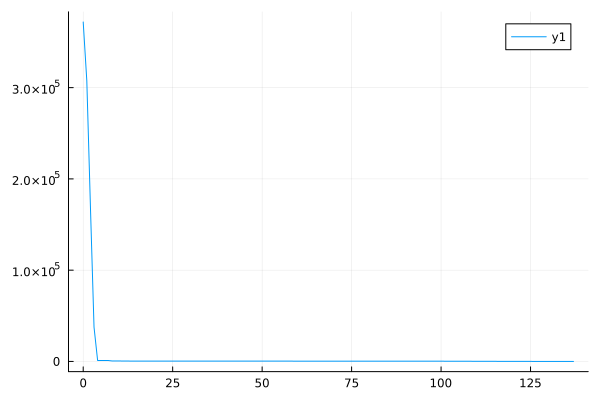

In [7]:
k = range(0, length(res.fk), length=length(res.fk))

plot(k, res.fk)

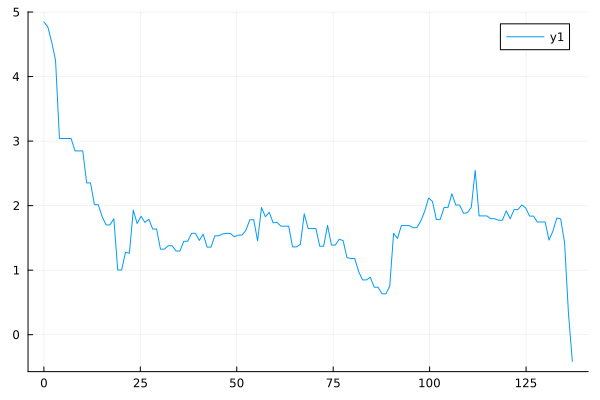

In [10]:
x = range(0, length(res.fk), length=length(res.fk))

plot(x, log10.(res.gk_norm))